In [1]:
import scanpy as sc

# Try to use GPU-accelerated rapids_singlecell, fall back to scanpy
try:
    import rapids_singlecell as rsc
    import cupy as cp
    import rmm
    from rmm.allocators.cupy import rmm_cupy_allocator
    USE_GPU = True
    print("Using GPU-accelerated rapids_singlecell")
except ImportError:
    rsc = sc
    USE_GPU = False
    print("rapids_singlecell not available, using scanpy (CPU)")

import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import os
import yaml

Using GPU-accelerated rapids_singlecell


/home/ncostigan/.local/share/mamba/envs/prisma/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if USE_GPU:
    rmm.reinitialize(
        managed_memory=False,
        pool_allocator=True,
        devices=0,
    )
    cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
CONFIG_PATH = "config/annotate.yaml"

with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

INPUT_FILE = config['input_file']
OUTPUT_DIR = config['output_dir']
OUTPUT_PREFIX = config['output_prefix']

# e.g., "cell_type_markers" -> annotation name "cell_type"
PANELS = {}
for panel_key, panel_path in config['panels'].items():
    annotation_name = panel_key.replace('_markers', '')
    PANELS[annotation_name] = panel_path

MIN_SCORE = config.get('min_score', None)

print(f"Loaded config from {CONFIG_PATH}")
print(f"Input: {INPUT_FILE}")
print(f"Output prefix: {OUTPUT_PREFIX}")
print(f"Min score threshold: {MIN_SCORE}")
print(f"Panels: {list(PANELS.keys())}")

Loaded config from config/annotate.yaml
Input: tma_processed.h5ad
Output prefix: tma
Min score threshold: 0.1
Panels: ['cell_type', 'cell_state', 'gbm_subtype']


In [4]:
sc.settings.figdir = os.path.join(OUTPUT_DIR, 'plots/annotate')
os.makedirs(sc.settings.figdir, exist_ok=True)

In [5]:
adata = sc.read_h5ad(INPUT_FILE)
print(f"Loaded: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"Clusters: {adata.obs['leiden'].nunique()} unique values")
print(f"\nCluster sizes:")
print(adata.obs['leiden'].value_counts())

Loaded: 383738 cells x 443 genes
Clusters: 16 unique values

Cluster sizes:
leiden
12    50895
11    37895
15    34977
9     29891
6     29686
13    27058
4     26826
8     24109
14    23282
1     20073
7     19626
0     14366
5     13397
2     13389
3     13380
10     4888
Name: count, dtype: int64


In [6]:
available_genes = set(adata.var_names)

def parse_panel(panel_path, annotation_name, available_genes):
    """Parse panel CSV into category -> gene list dictionary."""
    panel_df = pd.read_csv(panel_path)
    
    # Find the category column (should match annotation_name or be second column)
    if annotation_name in panel_df.columns:
        category_col = annotation_name
    else:
        # Use second column (first is 'gene')
        category_col = panel_df.columns[1]
    
    category_to_genes = defaultdict(list)
    for _, row in panel_df.iterrows():
        gene = row['gene']
        category = row[category_col]
        if gene in available_genes:
            category_to_genes[category].append(gene)
    
    return dict(category_to_genes)

panel_data = {}  # annotation_name -> {category -> [genes]}
for annotation_name, panel_path in PANELS.items():
    panel_data[annotation_name] = parse_panel(panel_path, annotation_name, available_genes)
    n_categories = len(panel_data[annotation_name])
    n_genes = sum(len(genes) for genes in panel_data[annotation_name].values())
    print(f"{annotation_name}: {n_categories} categories, {n_genes} genes in data")
    print(f"  Categories: {list(panel_data[annotation_name].keys())}")

cell_type: 14 categories, 73 genes in data
  Categories: ['Excitatory Neurons', 'OPCs', 'Oligodendrocytes', 'Astrocytes', 'Vascular Cells', 'Neural Stem Cells', 'Microglia', 'CD8+ T Cells', 'CD4+ T Cells', 'Regulatory T Cells ', 'Exhausted T Cells ', 'Tumor-Associated Macrophages', 'Glioblastoma (Cancer cells)', 'Glioblastoma (TME)']
cell_state: 4 categories, 18 genes in data
  Categories: ['Proliferation', 'Migration', 'Angiogenesis', 'Hypoxia']
gbm_subtype: 7 categories, 34 genes in data
  Categories: ['AC', 'G2/M', 'MES1', 'MES2', 'NPC1', 'NPC2', 'OPC']


In [7]:
def run_score_genes(adata, gene_list, score_name,  use_gpu=True):
    """
    Run score_genes using either rapids_singlecell (GPU) or scanpy (CPU).
    """
    valid_genes = [g for g in gene_list if g in adata.var_names]
    
    if len(valid_genes) == 0:
        print(f"  Warning: No valid genes for {score_name}")
        adata.obs[score_name] = 0.0
        return
    
    if use_gpu and USE_GPU:
        rsc.tl.score_genes(adata, valid_genes, score_name=score_name)
    else:
        sc.tl.score_genes(adata, valid_genes, score_name=score_name)

In [8]:
# score_genes expects log-normalized data, use counts layer if available
adata_score = adata.copy()

if USE_GPU:
    rsc.get.anndata_to_GPU(adata_score)

In [9]:
%%time
for annotation_name, category_to_genes in panel_data.items():
    print(f"Scoring {annotation_name}...")
    for category, genes in category_to_genes.items():
        score_name = f"score_{annotation_name}_{category.replace(' ', '_').replace('/', '_')}"
        run_score_genes(adata_score, genes, score_name, use_gpu=USE_GPU)
        print(f"  {category}: {len(genes)} genes")

Scoring cell_type...
  Excitatory Neurons: 1 genes
  OPCs: 2 genes
  Oligodendrocytes: 1 genes
  Astrocytes: 3 genes
  Vascular Cells: 3 genes
  Neural Stem Cells: 2 genes
  Microglia: 13 genes
  CD8+ T Cells: 6 genes
  CD4+ T Cells: 1 genes
  Regulatory T Cells : 3 genes
  Exhausted T Cells : 5 genes
  Tumor-Associated Macrophages: 7 genes
  Glioblastoma (Cancer cells): 4 genes
  Glioblastoma (TME): 22 genes
Scoring cell_state...
  Proliferation: 5 genes
  Migration: 6 genes
  Angiogenesis: 5 genes
  Hypoxia: 2 genes
Scoring gbm_subtype...
  AC: 6 genes
  G2/M: 2 genes
  MES1: 12 genes
  MES2: 2 genes
  NPC1: 5 genes
  NPC2: 3 genes
  OPC: 4 genes
CPU times: user 1.13 s, sys: 41.6 ms, total: 1.17 s
Wall time: 1.19 s


In [10]:
def aggregate_cluster_scores(adata, category_to_genes, annotation_name):
    """
    Aggregate per-cell scores to per-cluster mean scores.
    Returns a DataFrame with clusters as rows and categories as columns.
    """
    clusters = sorted(adata.obs['leiden'].unique(), key=lambda x: int(x) if str(x).isdigit() else x)
    
    results = {}
    for cluster in clusters:
        mask = adata.obs['leiden'] == cluster
        results[cluster] = {}
        
        for cat in category_to_genes.keys():
            cat_safe = cat.replace(' ', '_').replace('/', '_')
            col = f"score_{annotation_name}_{cat_safe}"
            if col in adata.obs.columns:
                values = adata.obs.loc[mask, col]
                results[cluster][cat] = np.mean(values)
    
    return pd.DataFrame(results).T

In [11]:
scores_data = {}  # annotation_name -> DataFrame of scores
for annotation_name, category_to_genes in panel_data.items():
    scores_data[annotation_name] = aggregate_cluster_scores(adata_score, category_to_genes, annotation_name)
    print(f"\n{annotation_name} scores per cluster:")
    display(scores_data[annotation_name])


cell_type scores per cluster:


,Excitatory Neurons,OPCs,Oligodendrocytes,Astrocytes,Vascular Cells,Neural Stem Cells,Microglia,CD8+ T Cells,CD4+ T Cells,Regulatory T Cells,Exhausted T Cells,Tumor-Associated Macrophages,Glioblastoma (Cancer cells),Glioblastoma (TME)
0,-0.394449,-0.462488,-0.232147,-1.300094,2.212100,0.710778,-0.061571,-0.007208,-0.214902,-0.018113,0.065699,-0.044150,-0.057972,-0.153688
1,-0.034101,-0.063478,-0.017514,0.060076,-0.356161,-0.112852,0.185013,-0.032078,0.237827,0.024134,-0.043959,0.107257,-0.047977,0.143163
2,-0.418808,-0.144315,-0.278640,-0.961353,1.978476,-0.085210,0.014449,0.040519,0.321179,-0.002996,-0.007366,0.059370,-0.011130,-0.093249
3,0.835382,-0.104824,0.402440,-0.213008,-0.217657,-0.223417,-0.219507,0.039912,-0.233082,-0.079029,-0.025490,-0.178950,-0.218071,-0.118378
4,-0.058644,0.215283,0.027795,0.202769,-0.250953,0.036262,-0.198095,-0.019592,-0.288056,0.000022,0.008917,-0.141653,-0.015391,-0.153864
5,-0.062141,0.180272,-0.063364,0.184129,-0.087807,0.031378,-0.166211,-0.003868,-0.218251,-0.004566,0.000253,-0.077813,0.010940,-0.098289
6,-0.030052,-0.000314,-0.018398,-0.024893,-0.029622,-0.015001,-0.051471,-0.008338,-0.110105,-0.002319,-0.012653,-0.014366,0.248992,-0.030734
7,-0.012869,-0.323455,-0.149500,-0.413560,-0.113422,-0.375573,0.320352,-0.020786,0.390955,0.002907,-0.036451,0.245328,-0.178650,0.250534
8,0.241955,-0.078321,0.196797,-0.195926,0.084894,-0.191409,-0.035328,0.016951,0.020843,-0.015096,0.021487,-0.000154,-0.042286,0.023715
9,-0.040894,-0.026738,-0.123493,0.169036,-0.238228,0.135910,-0.165719,-0.025839,-0.420106,-0.005010,-0.014471,-0.144529,0.380457,-0.172887



cell_state scores per cluster:


,Proliferation,Migration,Angiogenesis,Hypoxia
0,0.024025,-0.111302,0.526438,0.137656
1,-0.189820,0.032330,-0.124212,-0.131008
2,-0.183197,-0.008845,0.013837,0.013174
3,-0.042980,-0.034323,-0.050111,-0.131627
4,0.822482,-0.122574,-0.047171,-0.059808
5,1.026577,-0.088447,-0.037807,-0.005988
6,-0.072704,0.014828,0.131600,0.051992
7,-0.156488,0.096785,-0.125116,0.045107
8,0.020644,0.024439,0.015305,0.039587
9,-0.207441,-0.004254,0.074166,0.012088



gbm_subtype scores per cluster:


,AC,G2/M,MES1,MES2,NPC1,NPC2,OPC
0,-0.556939,-0.259851,0.201576,0.842916,-0.406695,-0.161829,-0.617418
1,0.006534,-0.329527,0.074540,-0.088499,-0.065967,-0.086212,-0.005773
2,-0.467776,-0.142724,0.499549,0.078351,-0.377172,-0.194367,-0.473772
3,-0.214139,-0.023306,-0.233033,-0.017180,0.242698,0.338959,-0.132574
4,0.014604,1.065336,-0.148218,-0.003453,0.298881,0.369097,0.112725
5,0.030480,1.496053,-0.183663,-0.012035,0.362118,0.479782,0.067238
6,-0.073374,-0.081306,0.140547,0.255079,-0.174425,-0.117780,-0.175645
7,-0.359715,-0.167145,0.008186,-0.042391,-0.239752,-0.200496,-0.349739
8,-0.140616,0.081443,-0.101864,0.053374,0.115664,0.211721,-0.128885
9,0.089260,-0.255472,0.417411,0.032529,-0.268838,-0.259662,-0.042854


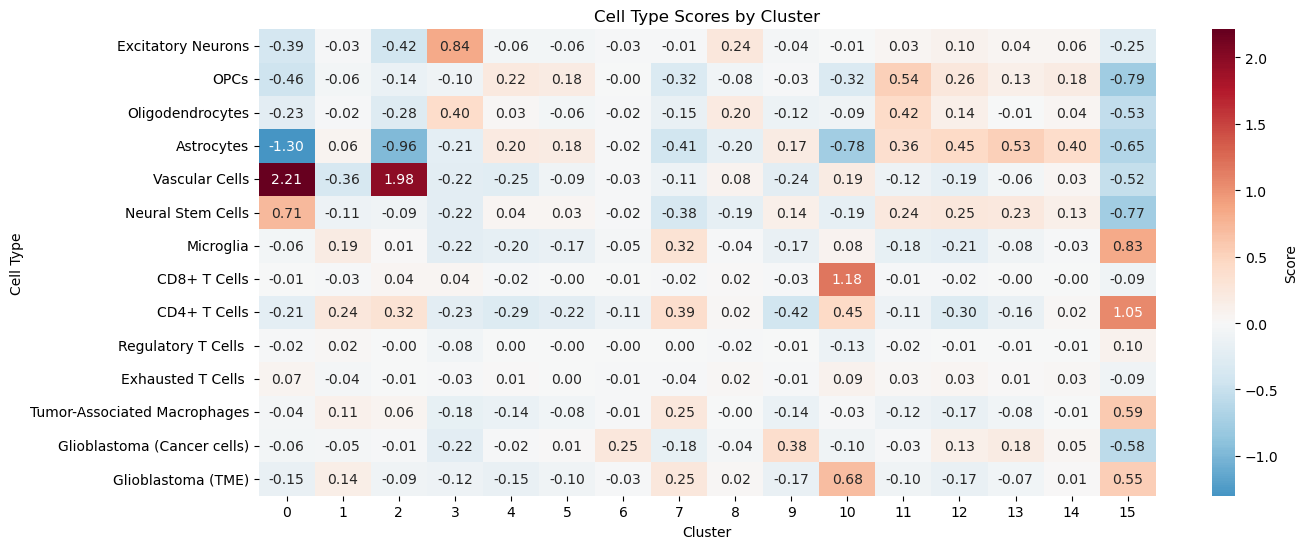

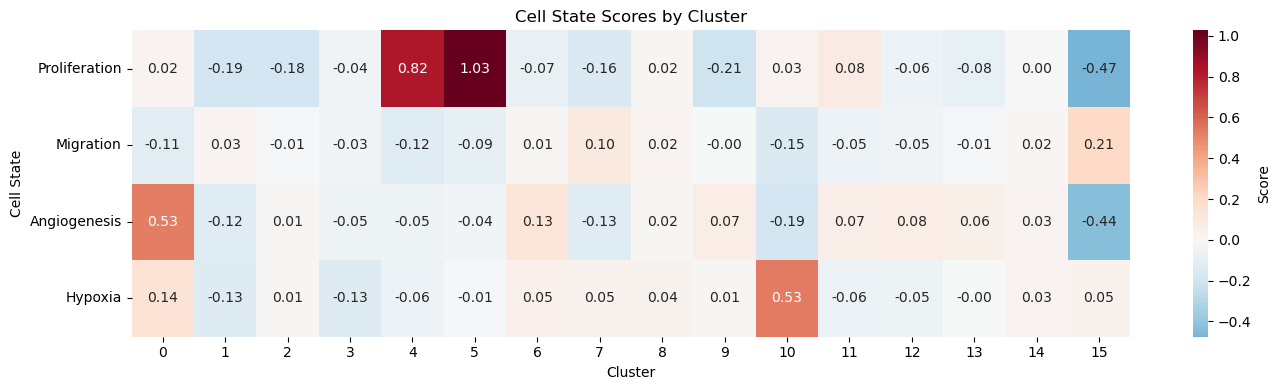

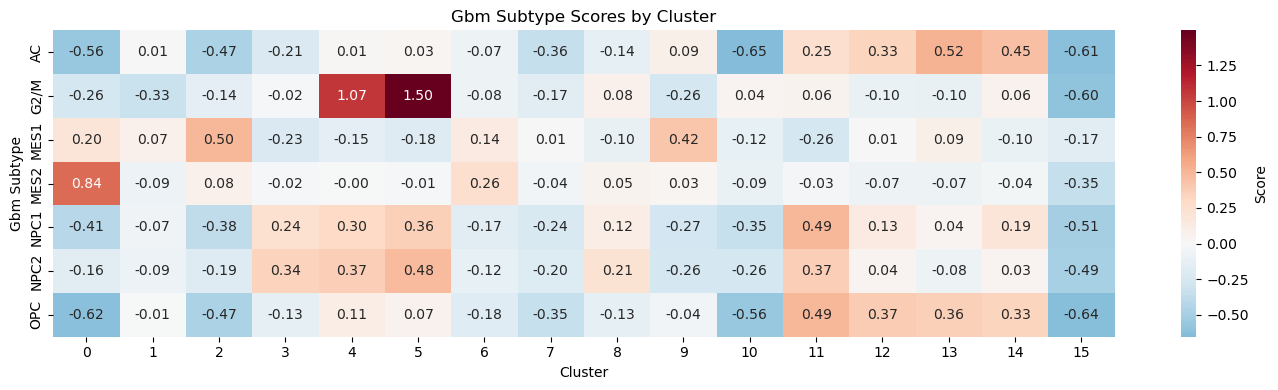

In [12]:
for annotation_name, scores_df in scores_data.items():
    n_categories = len(scores_df.columns)
    fig_height = max(4, n_categories * 0.4)
    
    fig, ax = plt.subplots(figsize=(14, fig_height))
    sns.heatmap(scores_df.T, cmap='RdBu_r', center=0, ax=ax,
                annot=True, fmt='.2f', cbar_kws={'label': 'Score'})
    ax.set_xlabel('Cluster')
    ax.set_ylabel(annotation_name.replace('_', ' ').title())
    ax.set_title(f'{annotation_name.replace("_", " ").title()} Scores by Cluster')
    plt.tight_layout()
    plt.savefig(f'{sc.settings.figdir}/{OUTPUT_PREFIX}_{annotation_name}_scores.png', dpi=150, bbox_inches='tight')
    plt.show()

In [13]:
def assign_annotation(scores_df, min_score=None, default='Unclassified'):
    """
    Assign annotation to each cluster based on highest score.
    Returns dict with cluster -> {primary, score, second, second_score, third, third_score}
    If min_score is set and highest score is below it, primary will be 'Unclassified'.
    """
    assignments = {}
    
    for cluster in scores_df.index:
        row = scores_df.loc[cluster]
        sorted_scores = row.sort_values(ascending=False)
        
        primary = sorted_scores.index[0]
        primary_score = sorted_scores.iloc[0]
        
        # Apply minimum score threshold
        if min_score is not None and primary_score < min_score:
            primary = default
        
        second = sorted_scores.index[1] if len(sorted_scores) > 1 else default
        second_score = sorted_scores.iloc[1] if len(sorted_scores) > 1 else 0
        
        third = sorted_scores.index[2] if len(sorted_scores) > 2 else default
        third_score = sorted_scores.iloc[2] if len(sorted_scores) > 2 else 0
        
        assignments[cluster] = {
            'primary': primary,
            'score': primary_score,
            'second': second,
            'second_score': second_score,
            'third': third,
            'third_score': third_score
        }
    
    return assignments

In [14]:
assignments_data = {}
for annotation_name, scores_df in scores_data.items():
    assignments_data[annotation_name] = assign_annotation(scores_df, min_score=MIN_SCORE)


def get_top_genes_for_category(adata, cluster, genes, n_top=3):
    """Get top expressing genes from a specific gene list for a cluster."""
    valid_genes = [g for g in genes if g in adata.var_names]
    if not valid_genes:
        return ""
    
    mask = adata.obs['leiden'] == cluster
    cluster_data = adata[mask, valid_genes]
    
    if hasattr(cluster_data.X, 'toarray'):
        mean_expr = np.array(cluster_data.X.toarray().mean(axis=0)).flatten()
    else:
        mean_expr = np.array(cluster_data.X.mean(axis=0)).flatten()
    
    top_indices = np.argsort(mean_expr)[::-1][:n_top]
    top_genes = [valid_genes[i] for i in top_indices]
    return ", ".join(top_genes)


summary_data = []
clusters = sorted(scores_data[list(scores_data.keys())[0]].index, key=lambda x: int(x) if str(x).isdigit() else x)

for cluster in clusters:
    n_cells = (adata.obs['leiden'] == cluster).sum()
    row = {'Cluster': cluster, 'N_Cells': n_cells}
    
    for annotation_name in assignments_data.keys():
        a = assignments_data[annotation_name][cluster]
        category_to_genes = panel_data[annotation_name]
        
        row[annotation_name] = a['primary']
        row[f'{annotation_name}_score'] = f"{a['score']:.3f}"
        if a['primary'] in category_to_genes:
            row[f'{annotation_name}_genes'] = get_top_genes_for_category(adata, cluster, category_to_genes[a['primary']])
        else:
            row[f'{annotation_name}_genes'] = ""
        
        row[f'{annotation_name}_2nd'] = a['second']
        row[f'{annotation_name}_2nd_score'] = f"{a['second_score']:.3f}"
        if a['second'] in category_to_genes:
            row[f'{annotation_name}_2nd_genes'] = get_top_genes_for_category(adata, cluster, category_to_genes[a['second']])
        else:
            row[f'{annotation_name}_2nd_genes'] = ""
        
        row[f'{annotation_name}_3rd'] = a['third']
        row[f'{annotation_name}_3rd_score'] = f"{a['third_score']:.3f}"
        if a['third'] in category_to_genes:
            row[f'{annotation_name}_3rd_genes'] = get_top_genes_for_category(adata, cluster, category_to_genes[a['third']])
        else:
            row[f'{annotation_name}_3rd_genes'] = ""
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("Cluster Annotations Summary:")
display(summary_df)

Cluster Annotations Summary:


,Cluster,N_Cells,cell_type,cell_type_score,cell_type_genes,cell_type_2nd,cell_type_2nd_score,cell_type_2nd_genes,cell_type_3rd,cell_type_3rd_score,...,cell_state_3rd_genes,gbm_subtype,gbm_subtype_score,gbm_subtype_genes,gbm_subtype_2nd,gbm_subtype_2nd_score,gbm_subtype_2nd_genes,gbm_subtype_3rd,gbm_subtype_3rd_score,gbm_subtype_3rd_genes
0,0,14366,Vascular Cells,2.212,"FLT1, RGS5, DCN",Neural Stem Cells,0.711,"ID1, NOTCH1",Exhausted T Cells,0.066,...,"KIT, CDK1, MKI67",MES2,0.843,"IGFBP3, CDKN1A",MES1,0.202,"FN1, A2M, IGFBP7",NPC2,-0.162,"SOX4, STMN1, SOX11"
1,1,20073,CD4+ T Cells,0.238,CD4,Microglia,0.185,"AIF1, APOE, TREM2",Glioblastoma (TME),0.143,...,"HIF1A, CXCR4",Unclassified,0.075,,AC,0.007,"S100B, SLC1A3, TTYH1",OPC,-0.006,"TTYH1, VCAN, BCAN"
2,2,13389,Vascular Cells,1.978,"DCN, RGS5, FLT1",CD4+ T Cells,0.321,CD4,Tumor-Associated Macrophages,0.059,...,"MMP9, MMP12, CTSL",MES1,0.500,"FN1, MGP, IGFBP7",MES2,0.078,"IGFBP3, CDKN1A",G2/M,-0.143,"PLK1, CENPF"
3,3,13380,Excitatory Neurons,0.835,NELL2,Oligodendrocytes,0.402,ERBB3,CD8+ T Cells,0.040,...,"VEGFA, CXCL2, FGF2",NPC2,0.339,"STMN1, SOX4, SOX11",NPC1,0.243,"STMN1, DLL3, SOX4",MES2,-0.017,"CDKN1A, IGFBP3"
4,4,26826,OPCs,0.215,"VCAN, PDGFRA",Astrocytes,0.203,"SOX9, S100B, SLC1A3",Neural Stem Cells,0.036,...,"HIF1A, CXCR4",G2/M,1.065,"CENPF, PLK1",NPC2,0.369,"STMN1, SOX11, SOX4",NPC1,0.299,"STMN1, SOX11, SOX4"
5,5,13397,Astrocytes,0.184,"S100B, SOX9, SLC1A3",OPCs,0.180,"PDGFRA, VCAN",Neural Stem Cells,0.031,...,"CXCL2, CXCL1, VEGFA",G2/M,1.496,"CENPF, PLK1",NPC2,0.480,"STMN1, SOX11, SOX4",NPC1,0.362,"STMN1, SOX11, BCAN"
6,6,29686,Glioblastoma (Cancer cells),0.249,"CD44, CAV1, ANXA1",OPCs,-0.000,"PDGFRA, VCAN",Regulatory T Cells,-0.002,...,"MMP12, MMP9, CTSL",MES2,0.255,"IGFBP3, CDKN1A",MES1,0.141,"CD44, SPP1, C1R",AC,-0.073,"SPARCL1, SPARC, SLC1A3"
7,7,19626,CD4+ T Cells,0.391,CD4,Microglia,0.320,"AIF1, TREM2, ITGAX",Glioblastoma (TME),0.251,...,"CXCL2, CXCL1, FLT1",Unclassified,0.008,,MES2,-0.042,"CDKN1A, IGFBP3",G2/M,-0.167,"PLK1, CENPF"
8,8,24109,Excitatory Neurons,0.242,NELL2,Oligodendrocytes,0.197,ERBB3,Vascular Cells,0.085,...,"KIT, CDK1, CENPF",NPC2,0.212,"STMN1, SOX11, SOX4",NPC1,0.116,"STMN1, DLL3, SOX11",G2/M,0.081,"PLK1, CENPF"
9,9,29891,Glioblastoma (Cancer cells),0.380,"CD44, ANXA1, CAV1",Astrocytes,0.169,"SOX9, SLC1A3, S100B",Neural Stem Cells,0.136,...,"CTSD, CTSB, CTSL",MES1,0.417,"C1S, C1R, CD44",AC,0.089,"SPARCL1, SLC1A3, TTYH1",MES2,0.033,"CDKN1A, IGFBP3"


In [15]:
leiden_str = adata.obs['leiden'].astype(str)

for annotation_name, assignments in assignments_data.items():
    cluster_to_annotation = {str(c): assignments[c]['primary'] for c in assignments}
    adata.obs[annotation_name] = leiden_str.map(cluster_to_annotation).astype('category')
    print(f"Added {annotation_name} annotation")

score_cols = [c for c in adata_score.obs.columns if c.startswith('score_')]
for col in score_cols:
    adata.obs[col] = adata_score.obs[col]

print(f"Added {len(score_cols)} score columns")

Added cell_type annotation
Added cell_state annotation
Added gbm_subtype annotation
Added 25 score columns


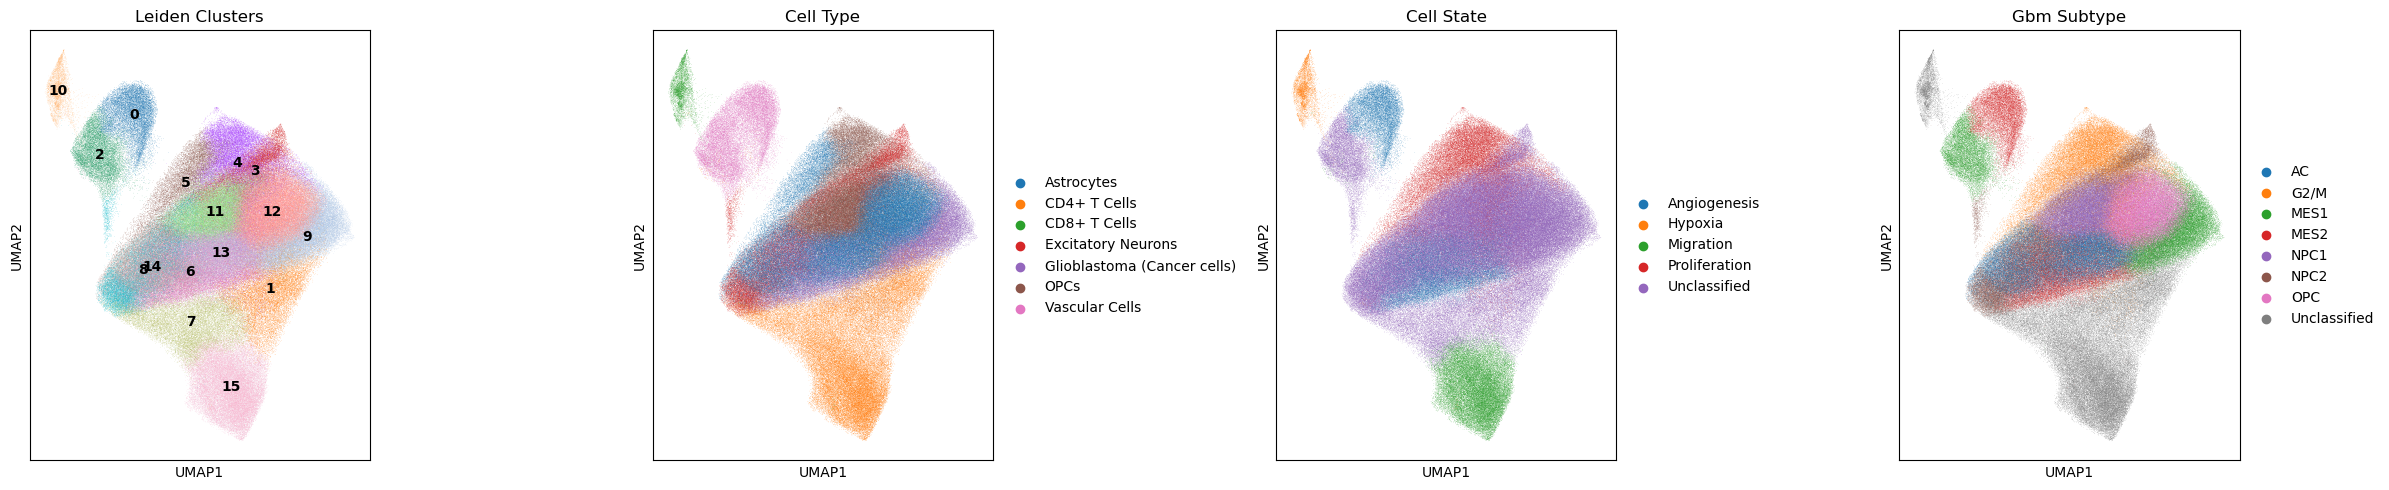

In [16]:
n_plots = 1 + len(assignments_data)
fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))

sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='Leiden Clusters', legend_loc='on data')

for idx, annotation_name in enumerate(assignments_data.keys(), start=1):
    sc.pl.umap(adata, color=annotation_name, ax=axes[idx], show=False, 
               title=annotation_name.replace('_', ' ').title())

plt.tight_layout()
plt.savefig(f'{sc.settings.figdir}/{OUTPUT_PREFIX}_umap_annotations.png', dpi=150, bbox_inches='tight')
plt.show()

Using spatial_original coordinates (multiple samples detected)


/tmp/ipykernel_1159467/3582143351.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_cats)


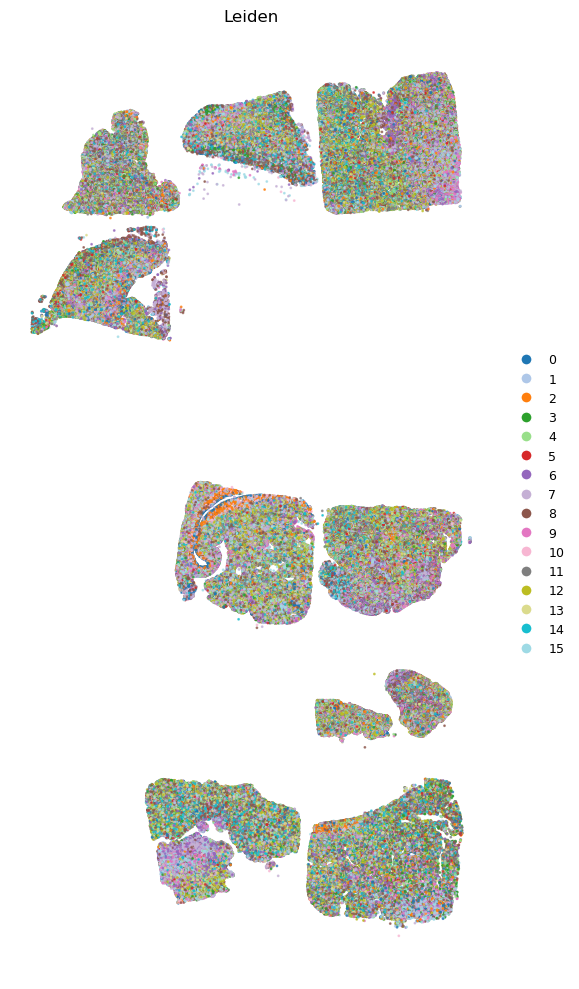

/tmp/ipykernel_1159467/3582143351.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_cats)


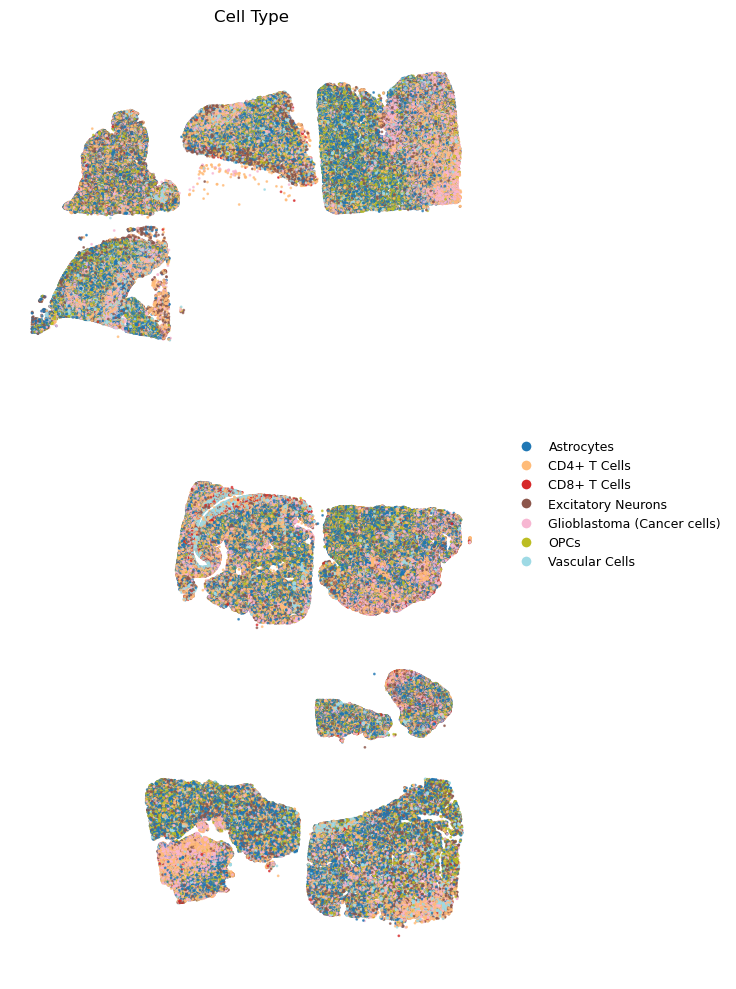

/tmp/ipykernel_1159467/3582143351.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_cats)


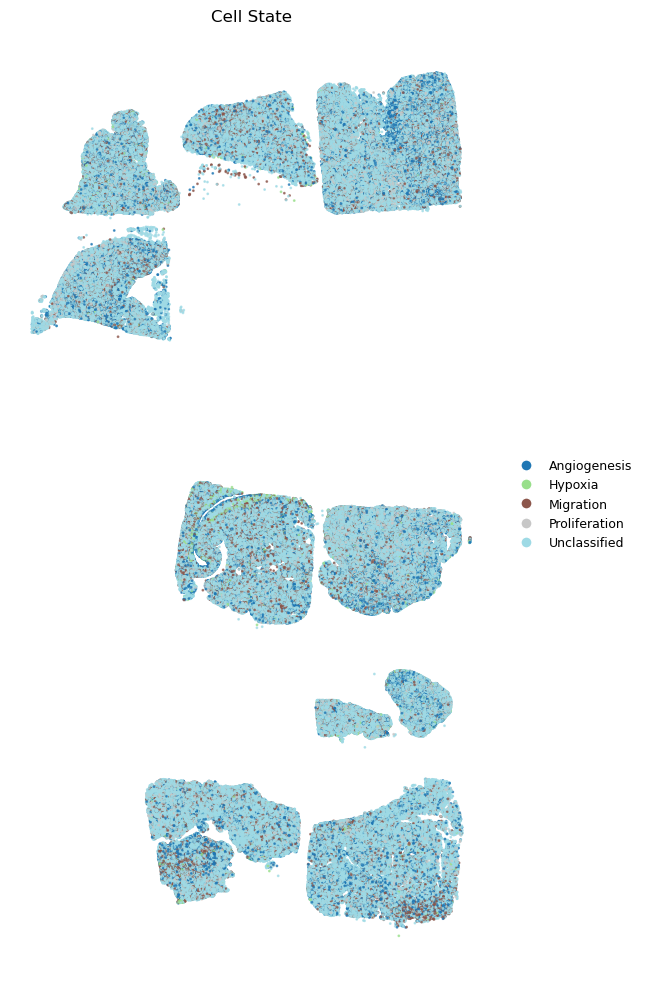

/tmp/ipykernel_1159467/3582143351.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_cats)


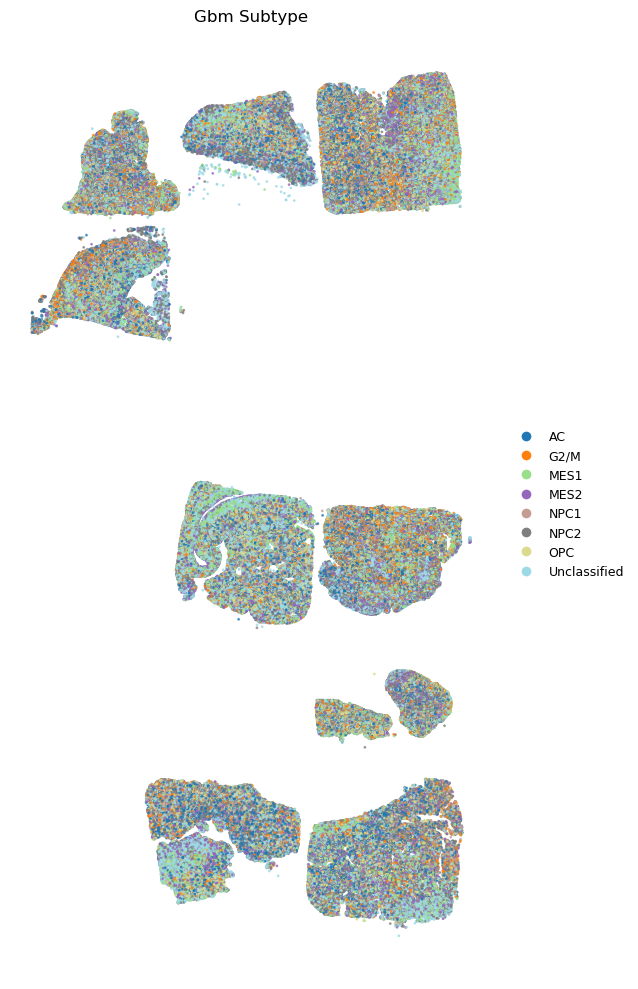

In [17]:
# Use spatial_original when available and multiple samples are present,
# since per-sample coordinates are reset to (0,0) and would overlap
if 'spatial' in adata.obsm:
    use_original = 'spatial_original' in adata.obsm and adata.obs['sample'].nunique() > 1
    coords = adata.obsm['spatial_original'] if use_original else adata.obsm['spatial']
    
    if use_original:
        print("Using spatial_original coordinates (multiple samples detected)")
    
    plot_cols = ['leiden'] + list(assignments_data.keys())
    
    for color in plot_cols:
        title = color.replace('_', ' ').title()
        categories = adata.obs[color].astype('category')
        cat_codes = categories.cat.codes
        cat_names = categories.cat.categories.tolist()
        n_cats = len(cat_names)
        
        cmap = plt.cm.get_cmap('tab20', n_cats)
        colors = [cmap(i) for i in range(n_cats)]
        
        fig, ax = plt.subplots(figsize=(12, 10))
        scatter = ax.scatter(coords[:, 0], coords[:, 1], 
                            c=cat_codes, cmap='tab20', 
                            s=1, alpha=0.7, vmin=0, vmax=n_cats-1)
        ax.set_title(title)
        ax.set_aspect('equal')
        ax.axis('off')
        
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=colors[i], markersize=8, label=cat_names[i])
                   for i in range(n_cats)]
        ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1.02, 0.5), 
                  frameon=False, fontsize=9)
        
        plt.tight_layout()
        plt.savefig(f'{sc.settings.figdir}/{OUTPUT_PREFIX}_spatial_{color}.png', dpi=150, bbox_inches='tight')
        plt.show()
else:
    print("No spatial coordinates found in adata.obsm['spatial']")

In [18]:
for annotation_name in assignments_data.keys():
    print(f"\n{annotation_name.upper().replace('_', ' ')} DISTRIBUTION")
    print("=" * 40)
    print(adata.obs[annotation_name].value_counts())


CELL TYPE DISTRIBUTION
cell_type
Astrocytes                     114632
CD4+ T Cells                    74676
OPCs                            64721
Glioblastoma (Cancer cells)     59577
Excitatory Neurons              37489
Vascular Cells                  27755
CD8+ T Cells                     4888
Name: count, dtype: int64

CELL STATE DISTRIBUTION
cell_state
Unclassified     259598
Angiogenesis      44052
Proliferation     40223
Migration         34977
Hypoxia            4888
Name: count, dtype: int64

GBM SUBTYPE DISTRIBUTION
gbm_subtype
Unclassified    79564
OPC             50895
AC              50340
MES2            44052
MES1            43280
G2/M            40223
NPC1            37895
NPC2            37489
Name: count, dtype: int64


In [19]:
output_path = os.path.join(OUTPUT_DIR, f'{OUTPUT_PREFIX}_annotated.h5ad')
adata.write_h5ad(output_path)
print(f"Saved annotated data to: {output_path}")

summary_path = os.path.join(sc.settings.figdir, f'{OUTPUT_PREFIX}_annotations.csv')
summary_df.to_csv(summary_path, index=False)
print(f"Saved annotation summary to: {summary_path}")

for annotation_name, scores_df in scores_data.items():
    scores_path = os.path.join(sc.settings.figdir, f'{OUTPUT_PREFIX}_{annotation_name}_scores.csv')
    scores_df.to_csv(scores_path)
    print(f"Saved {annotation_name} scores to: {scores_path}")

Saved annotated data to: ./tma_annotated.h5ad
Saved annotation summary to: plots/annotate/tma_annotations.csv
Saved cell_type scores to: plots/annotate/tma_cell_type_scores.csv
Saved cell_state scores to: plots/annotate/tma_cell_state_scores.csv
Saved gbm_subtype scores to: plots/annotate/tma_gbm_subtype_scores.csv
